# Global Branch

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.applications.resnet50 import ResNet50

2022-11-16 08:25:36.891553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data prep

### Import the image path file and process it

In [5]:
#import the path file
# import into df call paths the file '/home/julianzu9612/personalprojects/analitica/Vehiculos/cars_imagenes_Paths.xlsx' 
paths = pd.read_excel('/home/julianzu9612/personalprojects/analitica/Vehiculos/cars_imagenes_Paths.xlsx')
#delete the first column:
paths = paths.drop('Unnamed: 0', axis=1)
# in the column 'Path'replace '\\' for '/'
paths['Path'] = paths['Path'].str.replace('\\', '/')
#delete the column local:
paths = paths.drop('local', axis=1)
#delete from rows 344 onwards:
paths = paths.drop(paths.index[250:])
#print the shape of the df
print(paths.shape)
# print the last row of df:
print(paths.tail(1))
paths.head()

(250, 2)
                                                  Path  id_referencia
249  Vehiculos/AMC0462321905A391E_EDS_Quito_I5/2021...          249.0


/tmp/ipykernel_641/3149240437.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  paths['Path'] = paths['Path'].str.replace('\\', '/')


,Path,id_referencia
0,Vehiculos/AMC0462321905A391E_EDS_Quito_I5/2021...,1.0
1,Vehiculos/AMC046761F8F4D51A3_EDS_Quito_I6/2021...,1.0
2,Vehiculos/AMC0462321905A391E_EDS_Quito_I5/2021...,3.0
3,Vehiculos/AMC046761F8F4D51A3_EDS_Quito_I6/2021...,3.0
4,Vehiculos/AMC0462321905A391E_EDS_Quito_I5/2021...,5.0


In [6]:
# how many rows have paths:
print('The number of rows in paths is: ', paths.shape[0])


The number of rows in paths is:  250


### import the metadata and preprocess it

In [7]:
#import the json file in the path '/home/julianzu9612/personalprojects/analitica/Vehiculos/Data vehiculos /outs.json' in metadata:
metadata = pd.read_json('/home/julianzu9612/personalprojects/analitica/Vehiculos/Data vehiculos /outs.json')
metadata

,src,boxes,classes,scores
0,Vehiculos/AMC046761F8F4D51A3_EDS_Quito_I6/2021...,"[[316, 219, 364, 264], [172, 185, 227, 248], [...","[lamp, lamp, emblem]","[0.8612860073153421, 0.8290452508697611, 0.590..."
1,Vehiculos/AMC046761F8F4D51A3_EDS_Quito_I6/2021...,"[[22, 251, 92, 313], [242, 250, 313, 312], [14...","[lamp, lamp, emblem, emblem]","[0.991934284660764, 0.991210045599459, 0.55694..."
2,Vehiculos/AMC046761F8F4D51A3_EDS_Quito_I6/2021...,"[[249, 220, 309, 298], [164, 264, 202, 288], [...","[lamp, emblem, lamp]","[0.9688982031482141, 0.9437225152359291, 0.932..."
3,Vehiculos/AMC046761F8F4D51A3_EDS_Quito_I6/2021...,"[[117, 187, 187, 248], [227, 237, 254, 262], [...","[lamp, emblem, lamp]","[0.9933155331156761, 0.9565884892639501, 0.825..."
4,Vehiculos/AMC046761F8F4D51A3_EDS_Quito_I6/2021...,"[[50, 227, 117, 298], [247, 212, 310, 286], [1...","[lamp, lamp, emblem]","[0.9978600643925261, 0.994086136622193, 0.8282..."
...,...,...,...,...
405,Vehiculos/AMC0462321905A391E_EDS_Quito_I5/2021...,"[[320, 696, 377, 736], [143, 656, 236, 740], [...","[emblem, lamp, lamp]","[0.9926240240925771, 0.9815610370599681, 0.976..."
406,Vehiculos/AMC0462321905A391E_EDS_Quito_I5/2021...,"[[417, 315, 547, 450], [97, 359, 195, 474], [2...","[lamp, lamp, emblem]","[0.9871099297720671, 0.875297147870941, 0.4574..."
407,Vehiculos/AMC0462321905A391E_EDS_Quito_I5/2021...,"[[239, 440, 286, 470], [104, 402, 184, 472], [...","[emblem, lamp, lamp]","[0.985346964622664, 0.6398812014769141, 0.6249..."
408,Vehiculos/AMC0462321905A391E_EDS_Quito_I5/2021...,"[[401, 304, 505, 441], [246, 371, 303, 446], [...","[lamp, emblem, lamp]","[0.9925889441973221, 0.9785452452431681, 0.973..."


In [8]:
#how many rows have metadata:
print('The number of rows in metadata is: ', metadata.shape[0])


The number of rows in metadata is:  410


In [9]:
for i in paths['Path']:
    #find the index of the row in metadata src that have the path i:
    index = metadata[metadata['src'] == i].index
    #in a new column in metadata call 'id_ref' put the value of 'id_referencia' in the intex found:
    metadata.loc[index, 'id_ref'] = paths.loc[paths['Path'] == i, 'id_referencia'].values[0]

metadata.head(1)
    

,src,boxes,classes,scores,id_ref
0,Vehiculos/AMC046761F8F4D51A3_EDS_Quito_I6/2021...,"[[316, 219, 364, 264], [172, 185, 227, 248], [...","[lamp, lamp, emblem]","[0.8612860073153421, 0.8290452508697611, 0.590...",121.0


### Create the image paths

In [10]:
#show the rows in metadata with nan in the column 'id_ref':
len(metadata[metadata['id_ref'].isna()])
# delete rows where id_ref is nan:
metadata = metadata.dropna(subset=['id_ref'])
#show the rows in metadata with nan in the column 'id_ref':
len(metadata[metadata['id_ref'].isna()])



0

In [11]:
#convert the column 'id_ref' to int:
metadata['id_ref'] = metadata['id_ref'].astype(int)
metadata.head(1)

/tmp/ipykernel_641/485017908.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['id_ref'] = metadata['id_ref'].astype(int)


,src,boxes,classes,scores,id_ref
0,Vehiculos/AMC046761F8F4D51A3_EDS_Quito_I6/2021...,"[[316, 219, 364, 264], [172, 185, 227, 248], [...","[lamp, lamp, emblem]","[0.8612860073153421, 0.8290452508697611, 0.590...",121


In [12]:
#create a new colum in metadata call image_path and put the value of src:
metadata['image_path'] = metadata['src']
for i in metadata['image_path']:
    #put the value in each row with '/home/julianzu9612/personalprojects/analitica/Vehiculos/data_tg/train/ + 'id_ref' + '/' + 'file':
    metadata.loc[metadata['image_path'] == i, 'image_path'] = '/home/julianzu9612/personalprojects/analitica/Vehiculos/data_tg/train/' + str(metadata.loc[metadata['image_path'] == i, 'id_ref'].values[0]) + '/' + i.split('/')[-1]
metadata.head(1)


/tmp/ipykernel_641/2466652358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['image_path'] = metadata['src']


,src,boxes,classes,scores,id_ref,image_path
0,Vehiculos/AMC046761F8F4D51A3_EDS_Quito_I6/2021...,"[[316, 219, 364, 264], [172, 185, 227, 248], [...","[lamp, lamp, emblem]","[0.8612860073153421, 0.8290452508697611, 0.590...",121,/home/julianzu9612/personalprojects/analitica/...


In [13]:
#reset the index of metadata:
metadata = metadata.reset_index(drop=True)


### Original image descriptive

In [14]:
# import as image the path file from first row of metadata colum 'image_path':
image = plt.imread(metadata.loc[0, 'image_path'])
#show the shape of the image:
print(image.shape)
# create the list sizes:
sizes = []
# for each image_path in metadata calculate the size of the image and put it in a new variable call 'size':
for i in metadata['image_path']:
    #import the image:
    image = plt.imread(i)
    #append the shape of the image to the list sizes:
    sizes.append(image.shape)


(360, 388, 3)


In [15]:
#show first 5 elements of the list sizes:
sizes[:5]

[(360, 388, 3), (372, 362, 3), (381, 386, 3), (339, 371, 3), (349, 359, 3)]

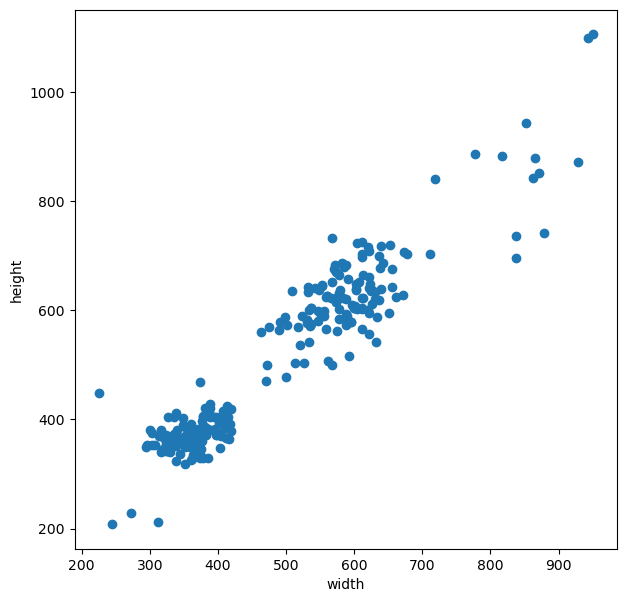

In [16]:
#plot the sizes as a scatter plot in a new canvas, x axis title as 'width', y axis title as 'height':
plt.figure(figsize=(7, 7))
plt.scatter([i[0] for i in sizes], [i[1] for i in sizes])
plt.xlabel('width')
plt.ylabel('height')
plt.show()

## Create the Masks

In [17]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
import skimage.io
import skimage.draw
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import cv2


In [18]:
def create_mask(image, metadata):

  # Load the original image
  image = skimage.io.imread(image)

  # Create the basic mask
  mask = np.ones(shape=image.shape[0:2], dtype="bool")

  # Draw a filled rectangle on the mask image
  for i in range(len(metadata['classes'])):

    rr, cc = skimage.draw.rectangle(start=(metadata['boxes'][i][1],metadata['boxes'][i][0]), end=(metadata['boxes'][i][3], metadata['boxes'][i][2]))
    mask[rr, cc] = False

  # Apply the mask
  image[mask] = 0

  #rezie the image to 224x224
  image = cv2.resize(image, (512, 512))
  # image = np.expand_dims(image, axis = 0)
  # image = ResNet50(weights= 'imagenet', include_top= False, input_shape= (512, 512, 3))(image)
  #convert image to a numpy array:
  image = np.array(image)
  return image

/home/julianzu9612/personalprojects/analitica/Vehiculos/data_tg/train/1/47[M][0@0][0]_veh.jpg
src           Vehiculos/AMC0462321905A391E_EDS_Quito_I5/2021...
boxes         [[393, 248, 480, 368], [254, 315, 312, 348], [...
classes                                    [lamp, emblem, lamp]
scores        [0.9611728306485291, 0.857245726221407, 0.7450...
id_ref                                                        1
image_path    /home/julianzu9612/personalprojects/analitica/...
Name: 213, dtype: object


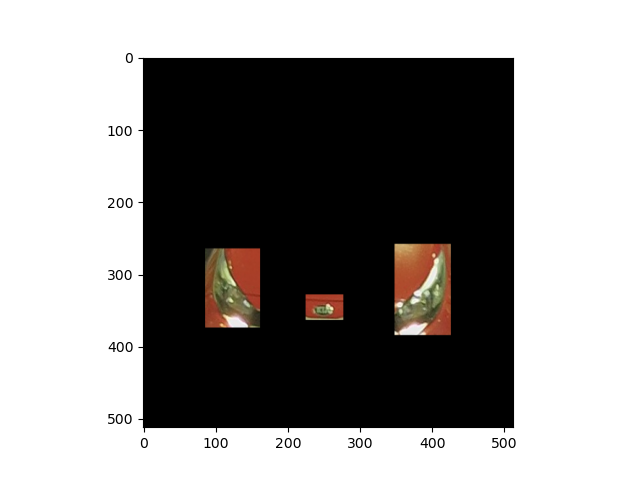

In [19]:
#test the function
#select the id referencia in i
i = 213
path = metadata['image_path'][i]
print(path)
route = metadata.iloc[i]
print(route)
image = create_mask(path, route)
fig, ax = plt.subplots()
plt.imshow(image)

In [138]:
type(image)

numpy.ndarray

## Triplet image prep

In [20]:
def triplet(id,rnd):
    triplet = []
    # create a random row of the df metadata where the column 'id_ref' different from id:
    # rnd = metadata[metadata['id_ref'] != id].sample(1)
    # rnd = rnd['id_ref'][0]
    #select the rows in metadata where the column 'id_ref' is id:
    a = metadata[metadata['id_ref'] == id]
    for i in a['image_path']:
        #import a image file from the path i:
        image = skimage.io.imread(i)
        #rezie the image to 224x224
        image = cv2.resize(image, (512, 512))
        # image = np.expand_dims(image, axis = 0)
        # image = ResNet50(weights= 'imagenet', include_top= False, input_shape= (512, 512, 3))(image)
        triplet.append(image)
    
    #assign in image the value of the image in the path in the column 'image_path' in the row rnd:
    image = skimage.io.imread(metadata['image_path'][rnd])
    # image = skimage.io.imread(rnd['image_path'].values[0])

    #append in triplet a random image from the rows in metadata where the column 'id_ref' is not id:
    # image = skimage.io.imread(metadata[metadata['id_ref'] != id]['image_path'].sample(1).values[0])
    image = cv2.resize(image, (512, 512))
    # image = np.expand_dims(image, axis = 0)
    # image = ResNet50(weights= 'imagenet', include_top= False, input_shape= (512, 512, 3))(image)
    triplet.append(image)
    
    return triplet

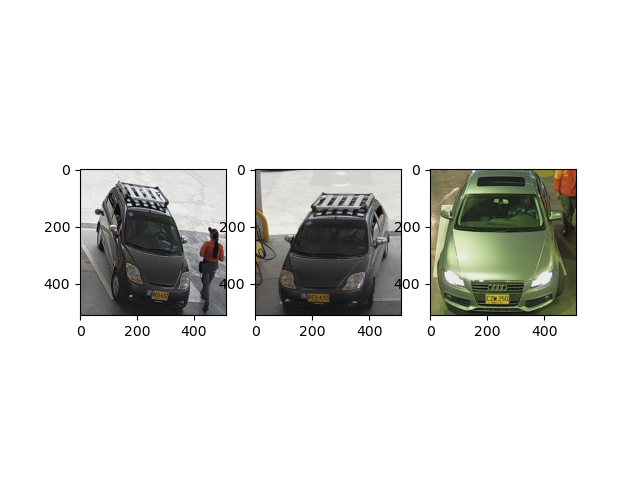

In [21]:
#test triplet function
a = triplet(9,1)
a
#plot the images in a:
fig, ax = plt.subplots(1,3)
ax[0].imshow(a[0])
ax[1].imshow(a[1])
ax[2].imshow(a[2])



In [22]:
def triplet_mask(id, rnd):
    triplet = []
    #select the rows in metadata where the column 'id_ref' is id:
    a = metadata[metadata['id_ref'] == id]
    for i in range(len(a['image_path'])):
        triplet.append(create_mask(a['image_path'].iloc[i], a.iloc[i]))
    #in a neaw varible b save a random id:
    # b = metadata[metadata['id_ref'] != id]['id_ref'].sample(1).values[0]
    # b = metadata[metadata['id_ref'] == b]
    # triplet.append(create_mask(b['image_path'].iloc[0], b.iloc[0]))

    a = metadata[metadata['id_ref'] == rnd]
    triplet.append(create_mask(metadata['image_path'][rnd], metadata.iloc[rnd]))
    return triplet
    

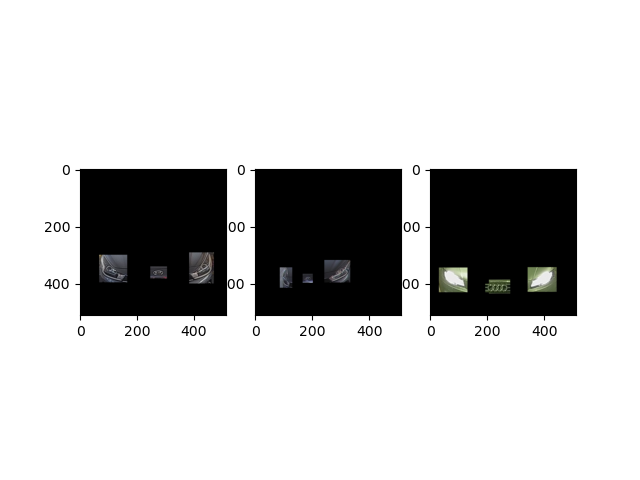

In [23]:
#test triplet_mask function:
a = triplet_mask(101, 1)
#for i in a plot the images:
fig, ax = plt.subplots(1,3)
for i in range(3):
    ax[i].imshow(a[i])



In [24]:
def triplet_set(id):
    rnd = metadata[metadata['id_ref'] != id].sample(1)
    rnd = rnd['id_ref'].values[0]
    a = triplet(id, rnd)
    b = triplet_mask(id, rnd)
    # create a dataset with column names 'image' and 'mask' and the values of a and b:
    dataset = pd.DataFrame({'image': a, 'mask': b})
    dataset['element_wise'] = dataset['image'] * dataset['mask']
    #convert dataset into a numpy array:
    # dataset = dataset.to_numpy()
    return dataset
    

In [25]:
a= triplet_set(1)
a

,image,mask,element_wise
0,"[[[72, 76, 77], [70, 75, 75], [69, 73, 74], [6...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,"[[[81, 94, 66], [82, 95, 67], [86, 99, 71], [8...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,"[[[194, 185, 188], [207, 198, 201], [221, 213,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [101]:
type(a['mask'][0])

numpy.ndarray

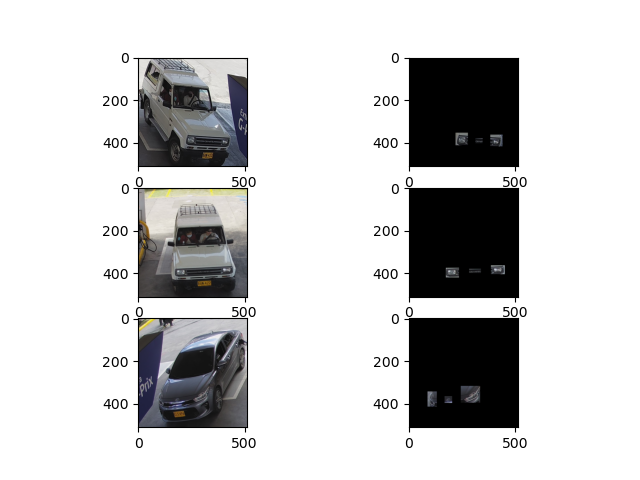

In [102]:
a = triplet_set(7)
#plot the images and mask in a fit in a 3x2 grid:
fig, ax = plt.subplots(3,2)
for i in range(3):
    ax[i,0].imshow(a['image'].iloc[i])
    ax[i,1].imshow(a['mask'].iloc[i])

In [26]:
def final_array(id):
    array = []
    array.append(triplet_set(id)['mask'])
    #swap values position 1 and 0:
    # array[0][0], array[0][1] = array[0][1], array[0][0]
    #convert array into a numpy array:
    array = np.array(array)
    return array

#test the function:
a = final_array(7)
a

array([[array([[[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               ...,

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],


In [92]:
type(a)

list

In [27]:
x = []
y = []
labels = []

for i in range(249):
    
    a = list(range(1,125,2))
    b = a.index(metadata['id_ref'][i])
    
    c = [0] * len(metadata['id_ref'].unique())
    c[b] = 1
    #convert c into a numpy array:
    c = np.array(c)
    y.append(c)
    print(y)
    if b in labels:
        d = final_array(metadata['id_ref'][i])
        d[0][0], d[0][1] = d[0][1], d[0][0]
        x.append(d)
    else:
        x.append(final_array(metadata['id_ref'][i]))
    #append in x final array function with the value of the id_ref in the row i:
    print(x)
    labels.append(b)

    if i == 2:
        break


[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]
[array([[array([[[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               [[0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                ...,
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0]],

               ...,

   

In [118]:
x

[array([[array([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 ...,
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]],
 
                [[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 ...,
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]],
 
                [[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 ...,
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]],
 
                ...,
 
                [[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 ...,
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]],
 
                [[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0],
                 ...,
                 [0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]],
 
            

In [109]:
type(y)

list

## Element wise product

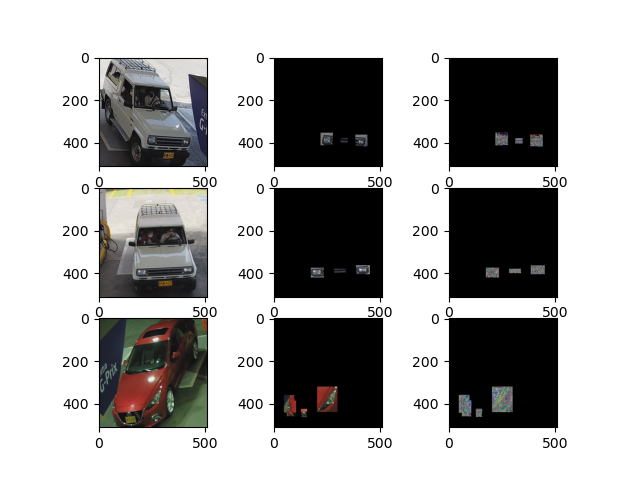

In [28]:
a = triplet_set(7)
#element wise multiplication of the images in the column 'image' in a and the images in the column 'mask' in a save in a new column in a named 'element_wise':
a['element_wise'] = a['image'] * a['mask']
#plot the images in a fit in a 3x3 grid:
fig, ax = plt.subplots(3,3)
for i in range(3):
    ax[i,0].imshow(a['image'].iloc[i])
    ax[i,1].imshow(a['mask'].iloc[i])
    ax[i,2].imshow(a['element_wise'].iloc[i])
    

## Modelo

In [29]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import  GlobalAveragePooling2D, AveragePooling2D, BatchNormalization, Activation, Dense, Flatten, concatenate, Input
from tensorflow.math import reduce_sum
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [30]:
inp = Input(shape=(512, 512, 3))

rn50 = ResNet50(weights= 'imagenet', include_top= False, input_shape= (512, 512, 3))(inp)
ap = AveragePooling2D(pool_size=(16, 16), strides=16)(rn50)
sumff = reduce_sum(ap, axis=2, keepdims= True)
sq = tf.squeeze(sumff, axis=2)
acti = Activation('relu')(sq)
bn = BatchNormalization()(acti)
w= Dense(2048, activation='softmax')(bn)
exp = tf.expand_dims(w, axis=2)
final = tf.multiply(exp, ap)


latt = Model(inp, final)
latt.summary()

2022-11-16 08:34:26.296041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 08:34:26.327141: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 2048)  0           ['resnet50[0][0]']               
 ing2D)                                                                                       

In [52]:
inp = Input(shape=(512, 512, 3))

rn50 = ResNet50(weights= 'imagenet', include_top= False, input_shape= (512, 512, 3))(inp)
ap = AveragePooling2D(pool_size=(16, 16), strides=16)(rn50)
sumff = reduce_sum(ap, axis=2, keepdims= True)
sq = tf.squeeze(sumff, axis=2)
acti = Activation('relu')(sq)
bn = BatchNormalization()(acti)
w= Dense(2048, activation='softmax')(bn)
exp = tf.expand_dims(w, axis=2)
final = tf.multiply(exp, ap)


latt = Model(inp, final)
latt.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 average_pooling2d_1 (AveragePo  (None, 1, 1, 2048)  0           ['resnet50[0][0]']               
 oling2D)                                                                                   

In [53]:
inp_anc = Input(shape=(512, 512, 3))
inp_pos = Input(shape=(512, 512, 3))
inp_neg = Input(shape=(512, 512, 3))

anc = latt(inp_anc)
pos = latt(inp_pos)
neg = latt(inp_neg)

concat = concatenate([anc, pos, neg], axis=1)

triplet_latt = Model([inp_anc, inp_pos, inp_neg], [concat, anc])
triplet_latt.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_9 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_10 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                          

In [32]:
def triplet_loss (alpha=0.3, poolsize=2048):
    def loss (y_true, y_pred):
        anc, pos, neg = y_pred[:, :poolsize], y_pred[:, poolsize:2*poolsize], y_pred[:, 2*poolsize:]
        dp = tf.reduce_mean(tf.square(anc - pos), axis=1)
        dn = tf.reduce_mean(tf.square(anc - neg), axis=1)
        return tf.maximum(dp - dn + alpha, 0.)
    return loss

In [55]:
triplet_latt.compile(loss=triplet_loss(alpha=0.3, poolsize=125), optimizer='adam', metrics=['accuracy'])

In [33]:
# copy metadata in matadata_mrr:
metadata_mrr = metadata.copy() 
#sort the values in metadata_mrr by id_ref:
metadata_mrr.sort_values(by=['id_ref'], inplace=True)
#reset the index of metadata_mrr:
metadata_mrr.reset_index(drop=True, inplace=True)
#create a new column in metadata_mrr using the last value of the column 'image_path' splited y '/':
metadata_mrr['image_name'] = metadata_mrr['image_path'].str.split('/').str[-1]

In [34]:
from PIL import Image

In [172]:
#create a folder named 'data_mk' in the same directory as the notebook:
os.mkdir('data_mk')
#into folder 'data_mk' create a folder named 'train':
os.mkdir('data_mk/train')
j = 0
h = []
for i in metadata_mrr['id_ref']:
    #validate if the folder 'data_mk/train' has a folder named 'i':
    if os.path.isdir('data_mk/train/'+str(i)) == False:
        os.mkdir('data_mk/train/' + str(i))
    #call function create_mask
    #if next function fails skip the iteration:
    try:
        array = create_mask(metadata_mrr['image_path'][j], metadata_mrr.iloc[j])
         #convert the numpy array into a image:
        img = Image.fromarray(array)
        #save the image in the folder 'data_mk/train/id_ref' with the name of metadata_mrr in column 'image_name' in the row j:
        img.save('data_mk/train/'+str(i)+'/'+metadata_mrr['image_name'][j])
    except:
        h.append(i)
        j += 1
        continue

    j += 1